In [1]:
import nbimporter

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm


#libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, truncnorm
from numpy.random import Generator, MT19937
import time
from scipy.special import logsumexp

In [2]:
#Initializing the random number generator
seed = int(time.time()) 
bitgen = MT19937(seed)
rng = Generator(bitgen)  # reproducible generator

In [3]:
#==========================Gaussian Target Distribution==========================
def target_pdf(x, mu=0, sigma=1.2):
    """
    Compute the PDF of a Gaussian distribution with mean 0 and standard deviation 1.
    """
    """Probability-density function of N(mu, sigma^2)."""
    z = (x - mu) / sigma
    return np.exp(-0.5 * z**2) / (sigma * np.sqrt(2 * np.pi)) #norm.pdf(x, mu, sigma)

In [4]:
def metropolis_hastings(xo, thinning, burnin, N, step_size):

    
    """
    Perform Metropolis-Hastings sampling to generate samples from a Gaussian distribution.
    
    Parameters:
    mu (float): Mean of the Gaussian distribution.
    sigma (float): Standard deviation of the Gaussian distribution.
    N (int): Number of samples to generate.
    
    Returns:
    np.ndarray: Array of samples from the Gaussian distribution.
    """
    accepted = 0
    samples = []
    x_current = xo  # Starting point
    
    for _ in range(N):
        # Propose a new sample from a normal distribution centered at the current sample
        x_proposed = x_current + rng.uniform(-step_size, step_size)
        
        # Compute acceptance ratio
        acceptance_ratio = target_pdf(x_proposed) / target_pdf(x_current) # this ratio assumes, that q(x_proposed | x_current) = q(x_current | x_proposed) = 1, which is the case for symmetric proposal distributions
        
        # Accept or reject the proposed sample
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed
            accepted += 1
        
        samples.append(x_current)
    # Calculate acceptance rate
    p_accept = accepted / len(samples)
    # Thinning: only keep every 'thinning'-th sample
    samples = samples[::thinning]
    # Burn-in: discard the first 'burnin' samples
    samples = samples[burnin:]
    samples = np.array(samples)
    
    print(p_accept)
    
    return np.array(samples), p_accept

    # Generate N samples from the target distribution (standard normal) using rng

In [5]:
def importance_integration(f, m_chain):
    # Compute the importance weights
    weights = f(m_chain) / target_pdf(m_chain)  # PDF of the target distribution
    estimate = np.mean(weights)  # Mean of the weights as the estimator of the integral
    
    return estimate

In [6]:
# Define the function f(x) = e^(-x^2)
def f(x):
    return np.exp(-x**2)


In [7]:
def blocking_variance(series, min_blocks=4):
    """
    Return
        bin_sizes  – powers-of-2 block lengths
        var_mean   – variance of the MCMC mean at each block size
        err_var    – 1-σ uncertainty of that variance
    """
    N = len(series)
    max_power = int(np.log2(N // min_blocks))
    bin_sizes = 2 ** np.arange(max_power + 1)

    var_mean, err_var = [], []
    for L in bin_sizes:
        n_blocks = N // L
        if n_blocks < min_blocks:               # need ≥ min_blocks estimates
            break
        # reshape   → one mean per block
        blocks = series[:n_blocks * L].reshape(n_blocks, L).mean(axis=1)

        s2      = blocks.var(ddof=1)            # unbiased σ² of block means
        v_mean  = s2 / n_blocks                 # Var[overall mean]
        var_mean.append(v_mean)

        # 1-σ error bar from χ² statistics
        err_var.append(v_mean * np.sqrt(2 / (n_blocks - 1)))

    return bin_sizes[:len(var_mean)], np.array(var_mean), np.array(err_var)

In [8]:
# ------------------------------------------------------------
# tiny plateau finder
# ------------------------------------------------------------
def plateau_variance(bin_sizes, variances, window=3, tolerance=0.04):
    """
    Mean of first 'window' consecutive points whose relative stdev < tolerance.
    Returns (variance_est, index_of_rightmost_point).
    """
    if len(variances) < window:
        return variances[-1], len(variances) - 1

    for i in range(len(variances) - window + 1):
        w = variances[i:i + window]
        if np.std(w) / np.mean(w) < tolerance:
            return np.mean(w), i + window - 1
    # fallback: last point
    return variances[-1], len(variances) - 1

0.45254
======  blocking-plateau variance estimate  ======
Var[mean] ≈ 4.6269e-05  ± 3.3e-06
Std error ≈ 6.8021e-03


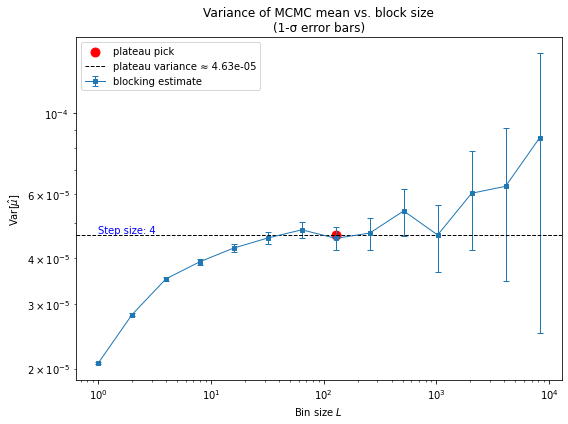

In [9]:
# --- 0. parameters ----------------------------------------

N = 100000  # Number of samples
step_size = 4  # Step size for the proposal distribution
xo = rng.uniform(-step_size, step_size)  # Initial point for the Markov chain rng.uniform(-step_size, step_size)
burnin = 1000  # Number of samples to discard as burn-in
thinning = 2  # Thinning factor for the Markov chain

# --- 1. generate a correlated chain (AR(1)) -----------------
markov_chain, prob_accept = metropolis_hastings(xo, thinning, burnin, N, step_size)

f_i = f(markov_chain)/ target_pdf(markov_chain)  # Importance weights for the samples

# --- 2. blocking analysis with error bars ------------------
bin_sizes, vars_mean, errs = blocking_variance(f_i)

# automatic plateau estimate
v_hat, idx = plateau_variance(bin_sizes, vars_mean)
err_hat    = errs[idx]

print("======  blocking-plateau variance estimate  ======")
print(f"Var[mean] ≈ {v_hat:.4e}  ± {err_hat:.1e}")
print(f"Std error ≈ {np.sqrt(v_hat):.4e}")

# 2. plot ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.errorbar(bin_sizes, vars_mean, yerr=errs,
             fmt='-s', capsize=3, linewidth=1, markersize=4,
             label='blocking estimate')
plt.scatter(bin_sizes[idx], v_hat, s=80, color='red',
            label='plateau pick')

# <<< NEW: horizontal line through the plateau value >>>
plt.axhline(v_hat, color='k', linestyle='--', linewidth=1,
            label=f'plateau variance ≈ {v_hat:.2e}')

plt.xscale('log'); plt.yscale('log')
plt.xlabel("Bin size $L$")
plt.ylabel(r"Var[$\hat\mu$]")
plt.title("Variance of MCMC mean vs. block size\n(1-σ error bars)")
plt.legend()
plt.tight_layout()
plt.text(bin_sizes[0], v_hat, f"Step size: {step_size}", fontsize=10, color='blue', verticalalignment='bottom')
plt.savefig(f"plots/Variance_of_MCMC_mean_vs_block_size_step={step_size}.pdf", format="pdf")
plt.show()
plt.close()


In [10]:
def plateau_vs_N(N_vals,
                 step_size=1,
                 burnin=1000,
                 thinning=2):
    """
    For every N in N_vals:
        • run a new MCMC chain
        • compute importance-weights series  f(chain)/target_pdf(chain)
        • do blocking + plateau pick
    Returns two NumPy arrays:  Ns,  plateau_variances
    """
    Ns   = []
    Vars = []
    var_err = []

    for N in N_vals:
        # 1. run chain
        xo = rng.uniform(-step_size, step_size)
        chain, _ = metropolis_hastings(xo, thinning, burnin, N, step_size)

        # 2. observable series
        weights = f(chain) / target_pdf(chain)

        # 3. blocking → plateau variance
        bins, v, _ = blocking_variance(weights)
        v_hat, idx   = plateau_variance(bins, v)
        err_hat    = errs[idx]


        Ns.append(N)
        Vars.append(v_hat)
        var_err.append(err_hat)

    return np.array(Ns), np.array(Vars), np.array(var_err)


In [11]:
N_list = np.logspace(3.7, 4, num=50, dtype=int)#[5_000, 6000, 7000, 8000, 9000, 10_000, 12500, 15000, 20_000, 25000, 30000, 35000, 40_000]

Ns, plateau_var, var_err = plateau_vs_N(N_list, step_size=4, burnin=1000, thinning=2)

print("N       plateau-var")
for N, v in zip(Ns, plateau_var):
    print(f"{N:7d}   {v:.3e}")


0.45220514867291955
0.4517017509344875
0.44267701260911735
0.4584927314460597
0.44832138815541306
0.46475729960944767
0.46112944627796115
0.4447658651238474
0.44901960784313727
0.4698541044120232
0.4587521663778163
0.45437457279562543
0.4572872788542544
0.44525668715733513
0.44815724815724817
0.44315245478036175
0.465042204172639
0.4525043177892919
0.45595293389069513
0.463593344527553
0.45770620108368454
0.4651231819531018
0.45390693590869186
0.46154955994805946
0.4532650448143406
0.465843736849488
0.4479944674965422
0.45738442656484385
0.4626865671641791
0.46016173936099697
0.4603921568627451
0.45978344934261406
0.45856634468734114
0.4525062656641604
0.4573758339510749
0.4586988304093567
0.4566966966966967
0.4493663389790359
0.45112694149246757
0.45261945883707544
0.46105812897366033
0.450016791671331
0.46876379690949227
0.4549412276882891
0.453160210322996
0.4515924240821077
0.45122587376108503
0.4543771216952988
0.4545638945233266
0.4499
N       plateau-var
   5011   1.175e-03
   5

In [12]:
from Uniform_MC import uniform_mc_integrate

stderrs_u = []
integral_u = []

#uniform_mc_integrate(f, a, b, N, rng)
for N in N_list:
    integral_u, stderr_u = uniform_mc_integrate(f, -10, 10, N, rng)
    stderrs_u.append(stderr_u)
stderrs_u = np.array(stderrs_u)


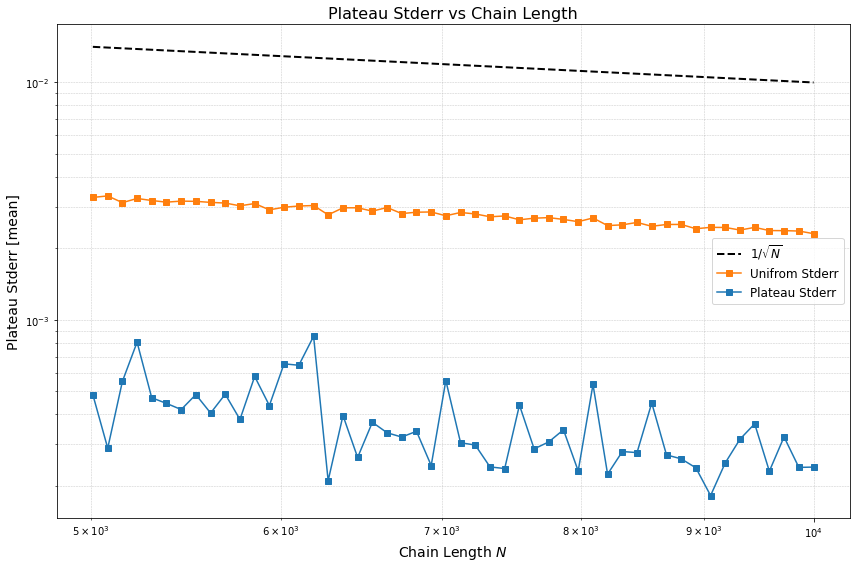

In [13]:
plt.figure(figsize=(12, 8))
plt.loglog(Ns, 1 / np.sqrt(Ns), '--', color='k', linewidth=2, label=r'$1/\sqrt{N}$')
plt.errorbar(Ns, np.sqrt(plateau_var/Ns), fmt='-s', capsize=8, label='Plateau Stderr')
plt.loglog(Ns, stderrs_u, '-s', label='Unifrom Stderr')
plt.xlabel("Chain Length $N$", fontsize=14)
plt.ylabel("Plateau Stderr [mean]", fontsize=14)
plt.title("Plateau Stderr vs Chain Length", fontsize=16)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/Plateau_Stderr_vs_Chain_Lengthstep={step_size}.pdf", format="pdf")
plt.show()

In [14]:
N_list = np.logspace(1, 4, num=50, dtype=int)#[5_000, 6000, 7000, 8000, 9000, 10_000, 12500, 15000, 20_000, 25000, 30000, 35000, 40_000]


In [17]:
xo = rng.uniform(-step_size, step_size)
thinning = 1
burnin = 1
step_size = 4

# Reinitialize as lists to avoid AttributeError
stderrs_u = []
integrals_u = []
integrals_i = []

#uniform_mc_integrate(f, a, b, N, rng)
for N in N_list:
    integral_u, stderr_u = uniform_mc_integrate(f, -10, 10, N, rng)
    m_chain, _ = metropolis_hastings(xo, thinning, burnin, N, step_size)
    integral_i = importance_integration(f, m_chain)
    stderrs_u.append(stderr_u)
    integrals_u.append(integral_u)
    integrals_i.append(integral_i)

stderrs_u = np.array(stderrs_u)
integrals_u = np.array(integrals_u)
integrals_i = np.array(integrals_i)

0.3
0.5454545454545454
0.5384615384615384
0.6
0.5294117647058824
0.4
0.6086956521739131
0.4230769230769231
0.5333333333333333
0.45714285714285713
0.4
0.3617021276595745
0.37037037037037035
0.5
0.4507042253521127
0.4268292682926829
0.5789473684210527
0.41284403669724773
0.3968253968253968
0.47586206896551725
0.41317365269461076
0.45077720207253885
0.44144144144144143
0.43137254901960786
0.45918367346938777
0.45132743362831856
0.441025641025641
0.4610244988864143
0.42166344294003866
0.4463087248322148
0.47667638483965014
0.43291139240506327
0.45274725274725275
0.44656488549618323
0.4461028192371476
0.45500359971202303
0.43151969981238275
0.4793702497285559
0.4641509433962264
0.4426699426699427
0.4407684098185699
0.4581402533209762
0.4437885698953582
0.4516429736658122
0.45557579437360857
0.4593074354016523
0.4516867653793314
0.45472623624552566
0.46090961427748994
0.4617


In [21]:
# Number of repetitions
repetitions = 15

# Initialize arrays to store results from each repetition
all_integrals_u = []
all_integrals_i = []

for _ in range(repetitions):
    stderrs_u = []
    integrals_u = []
    integrals_i = []

    # Uniform MC and Importance Sampling
    for N in N_list:
        integral_u, stderr_u = uniform_mc_integrate(f, -10, 10, N, rng)
        stderrs_u.append(stderr_u)
        integrals_u.append(integral_u)
        m_chain, _ = metropolis_hastings(xo, thinning, burnin, N, step_size)
        integral_i = importance_integration(f, m_chain)
        integrals_i.append(integral_i)

    all_integrals_u.append(integrals_u)
    all_integrals_i.append(integrals_i)

# Convert to numpy arrays for easier computation
all_integrals_u = np.array(all_integrals_u)
all_integrals_i = np.array(all_integrals_i)

# Compute averages and standard errors column-wise
avg_integrals_u = np.mean(all_integrals_u, axis=0)
avg_integrals_i = np.mean(all_integrals_i, axis=0)
stderr_integrals_u = np.std(all_integrals_u, axis=0, ddof=1) / np.sqrt(repetitions)
stderr_integrals_i = np.std(all_integrals_i, axis=0, ddof=1) / np.sqrt(repetitions)
'''
stderrs_u = []
integrals_u = []
integrals_i = []


step_size = 4
xo = rng.uniform(-step_size, step_size)
thinning = 1
burnin = 1


#uniform_mc_integrate(f, a, b, N, rng)
for N in N_list:
    integral_u, stderr_u = uniform_mc_integrate(f, -10, 10, N, rng)
    stderrs_u.append(stderr_u)
    integrals_u.append(integral_u)
    m_chain, _ = metropolis_hastings(xo, thinning, burnin, N, step_size)
    integral_i = importance_integration(f, m_chain)
    integrals_i.append(integral_i)

stderrs_u = np.array(stderrs_u)
integrals_u = np.array(integrals_u)
integrals_i = np.array(integrals_i)


analytical_result = np.sqrt(np.pi)'''



0.3
0.36363636363636365
0.46153846153846156
0.4
0.5882352941176471
0.4
0.43478260869565216
0.3076923076923077
0.4
0.6
0.575
0.46808510638297873
0.5370370370370371
0.4032258064516129
0.5211267605633803
0.5487804878048781
0.3684210526315789
0.4036697247706422
0.4523809523809524
0.46206896551724136
0.49101796407185627
0.46113989637305697
0.4189189189189189
0.44313725490196076
0.4897959183673469
0.4365781710914454
0.4307692307692308
0.44543429844098
0.44294003868471954
0.4446308724832215
0.4606413994169096
0.4189873417721519
0.46593406593406594
0.48759541984732824
0.45356550580431176
0.4535637149028078
0.4452782989368355
0.4576547231270358
0.47924528301886793
0.4484029484029484
0.4429028815368196
0.44701884460920605
0.448349879259458
0.45024469820554647
0.45699251163732035
0.4545614343469854
0.4440543428484201
0.45141190507755535
0.452964881980426
0.4539
0.7
0.45454545454545453
0.38461538461538464
0.5333333333333333
0.47058823529411764
0.6
0.5217391304347826
0.38461538461538464
0.433333333

'\nstderrs_u = []\nintegrals_u = []\nintegrals_i = []\n\n\nstep_size = 4\nxo = rng.uniform(-step_size, step_size)\nthinning = 1\nburnin = 1\n\n\n#uniform_mc_integrate(f, a, b, N, rng)\nfor N in N_list:\n    integral_u, stderr_u = uniform_mc_integrate(f, -10, 10, N, rng)\n    stderrs_u.append(stderr_u)\n    integrals_u.append(integral_u)\n    m_chain, _ = metropolis_hastings(xo, thinning, burnin, N, step_size)\n    integral_i = importance_integration(f, m_chain)\n    integrals_i.append(integral_i)\n\nstderrs_u = np.array(stderrs_u)\nintegrals_u = np.array(integrals_u)\nintegrals_i = np.array(integrals_i)\n\n\nanalytical_result = np.sqrt(np.pi)'

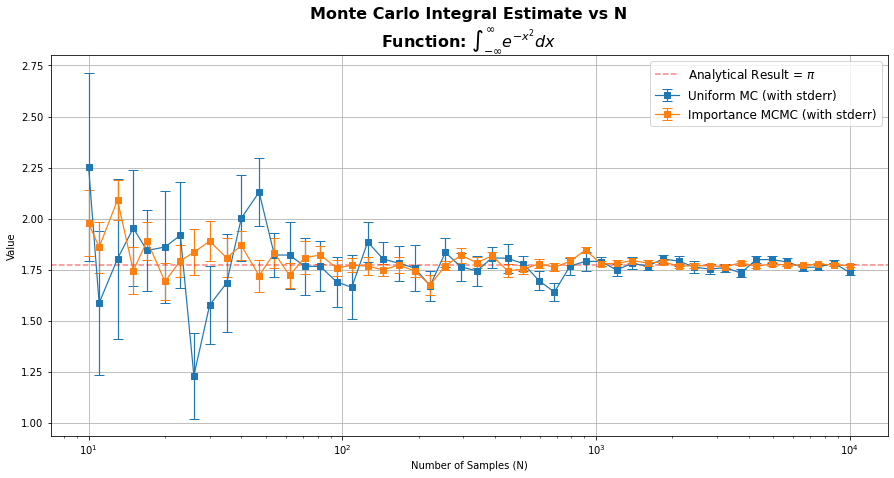

In [23]:
plt.figure(figsize=(15, 7))
plt.rcParams.update({'axes.titlesize': 16, 'axes.titleweight': 'bold', 'axes.titlepad': -20})
plt.errorbar(N_list, avg_integrals_u, yerr=stderr_integrals_u, fmt='-s', capsize=5, label='Uniform MC (with stderr)', linewidth=1.2, alpha=1)
plt.errorbar(N_list, avg_integrals_i, yerr=stderr_integrals_i, fmt='-s', capsize=5, label='Importance MCMC (with stderr)', linewidth=1.2, alpha=1)
# Plot estimates with error bars
analytical_result = np.sqrt(np.pi)
plt.axhline(y=analytical_result, color='red', linestyle='--', label=r'Analytical Result = $\pi$', alpha=0.5)
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Value')
function_description = r"$\int_{-\infty}^{\infty}e^{-x^2}dx$"  # Update the function description with infinity symbol
plt.title(f'Monte Carlo Integral Estimate vs N\nFunction: {function_description}', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.grid(True)
plt.savefig(f"plots/'Uniform_vs_MCMC_IMP{function_description}_step={step_size}.pdf", format="pdf")
plt.show()